In [1]:
import importlib, os, gc, sys
import SXBQ as sx
import WMT_functions as wmt
import matplotlib.dates as mdates
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve, fmin
from scipy.signal import convolve as conv
import gsw
import cmocean.cm as cmo
from datetime import datetime as dt
import matplotlib.dates as mdates
import math

import matplotlib.colors as cl
from gsw import z_from_p, p_from_z, distance, SA_from_SP, CT_from_t, rho, distance, cp_t_exact


from scipy.signal import find_peaks
from scipy.stats import linregress


from matplotlib.gridspec import GridSpec

import glidertools as gt
import matplotlib.colors as colors
import matplotlib.cm as cm

from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec

import seaborn as sns
sns.set(    rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'Black',
         'axes.facecolor': 'white',
         'axes.grid': False,
         'axes.labelcolor': 'k',
            
         'axes.spines.right': True,
         'axes.spines.top': True,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'k',
         'patch.force_edgecolor': True,
         'text.color': 'k',
         'xtick.bottom': True,
         'xtick.color': 'k',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'k',
         'ytick.direction': 'out',
         'ytick.left': True,
         'ytick.right': False},
         font_scale=1.6)

import warnings
warnings.filterwarnings('ignore')

def interp(x,y,xi):
    _gg = np.isfinite(x+y)
    return interp1d(x[_gg], y[_gg], bounds_error=False, fill_value=np.NaN)(xi)

## Import data

In [2]:
df_bath=xr.open_dataset('/home/jupyter-estelfont/scratch/estel/datasets/bathymetry/gebco_2023_n30.0_s-5.0_w30.0_e80.0.nc')
df_bath=df_bath.where(df_bath.lat>20, drop=True).where(df_bath.lon<62, drop=True).where(df_bath.lon>55, drop=True).where(df_bath.lat<28, drop=True)
### PLOT ARGO N2
ds_grid_argo=xr.open_dataset('/home/jupyter-estelfont/datasets/argo/ModeWater_SoO/L1_vertical_interp/ARGO_SoO_2000_2024_PP_interp_1m_z.nc')
mask = ds_grid_argo['profile_number'].isin(ds_grid_argo.salinity.where(ds_grid_argo.salinity<35, drop=True).profile_number.values)
mask
# Apply the mask to set NaN in temperature where profile_number is 10
ds_grid_argo['temperature'] = ds_grid_argo['temperature'].where(~mask, np.nan)
ds_grid_argo['salinity'] = ds_grid_argo['salinity'].where(~mask, np.nan)

# ds_grid_argo=ds_pp_interp.copy()
# ds_grid_argo['salinity']=ds_grid_argo.salinity.where(ds_grid_argo.salinity>35, np.nan)

# ds_grid_argo

ds_grid_argo['abs_salinity']=gsw.SA_from_SP(ds_grid_argo.salinity, ds_grid_argo.pressure, 58, 24.5)
ds_grid_argo['cons_temp']=gsw.CT_from_t(ds_grid_argo.abs_salinity, ds_grid_argo.temperature, ds_grid_argo.pressure)
ds_grid_argo['spice']=gsw.spiciness0(ds_grid_argo.abs_salinity, ds_grid_argo.cons_temp)
ds_grid_argo['pot_density']=gsw.sigma0(ds_grid_argo.abs_salinity, ds_grid_argo.cons_temp)

ds_grid_argo=ds_grid_argo.set_coords('time').set_coords('latitude').set_coords('longitude').where(np.isfinite(ds_grid_argo.latitude), drop=True)
ds_grid_argo=ds_grid_argo.where(ds_grid_argo.latitude>22, drop=True)#.where(ds_grid_argo.longitude<60.25, drop=True)

mask_profiles_bathimetry=(df_bath.elevation.interp(lat=ds_grid_argo.latitude, lon=ds_grid_argo.longitude))<-1000
ds_grid_argo=ds_grid_argo.where(mask_profiles_bathimetry, drop=True)

ds_grid_argo['N2']=ds_grid_argo['abs_salinity'].copy()*np.nan
ds_grid_argo['N2'][:, :-1]=gsw.Nsquared(ds_grid_argo['abs_salinity'], ds_grid_argo['cons_temp'], ds_grid_argo.pressure, axis=1)[0]

ds_grid_argo_month=ds_grid_argo.swap_dims({'profile_number':'time'}).sortby('time').groupby('time.month')#.sel(time=slice('2015'))

## Mask, grid data

In [3]:
start_lat, start_lon = 23.7, 58.5
end_lat, end_lon = 25.4, 60.1
num_points=400
from math import radians, sin, cos, sqrt, atan2
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of the Earth in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c  # Distance in kilometers


# Find the closest point in a list to a given point
def find_closest_point(lat, lon, lats, lons):
    min_distance = float('inf')
    closest_point = None
    closest_index = -1
    for i in range(len(lats)):
        distance = haversine(lat, lon, lats[i], lons[i])
        if distance < min_distance:
            min_distance = distance
            closest_point = (lats[i], lons[i])
            closest_index = i
    return closest_point, min_distance, closest_index, distance_on_the_transect[closest_index]

    # plt.plot([56.5,62], [26, 22.5], c='r')

start_lat
# Generate linearly spaced points between start and end lat/lon
lats = np.linspace(start_lat, end_lat, num_points)
lons = np.linspace(start_lon, end_lon, num_points)

distance_on_the_transect=[0]
for i in range(len(lats)-1):
    distance_on_the_transect.append(haversine(lats[i], lons[i], lats[i+1], lons[i+1]))
    
distance_on_the_transect=np.cumsum(distance_on_the_transect)

# Reference point for comparison
ref_lats, ref_lons = ds_grid_argo.latitude.values, ds_grid_argo.longitude.values # Example reference point

new_lat, new_lon, distance_to_transect, distance_on_transect_pp = [],[],[], []
# Iterate over each reference point and find the closest point
for ref_lat, ref_lon in zip(ref_lats, ref_lons):
    closest_point, distance, closest_index, distance_on = find_closest_point(ref_lat, ref_lon, lats, lons)
    if closest_point==None:
        new_lat.append(np.nan)
        new_lon.append(np.nan)
        distance_to_transect.append(np.nan)
        distance_on_transect_pp.append(np.nan)
        
    else:
        new_lat.append(closest_point[0])
        new_lon.append(closest_point[1])
        distance_to_transect.append(distance)
        distance_on_transect_pp.append(distance_on)  
        
ds_grid_argo['lat_on_transect_across']=('profile_number', np.array(new_lat))   
ds_grid_argo['lon_on_transect_across']=('profile_number', np.array(new_lon))    
ds_grid_argo['distance_from_transect_across']=('profile_number', np.array(distance_to_transect))
ds_grid_argo['distance_bin_on_transect_across']=('profile_number', np.array(distance_on_transect_pp))


(22.0, 26.5)

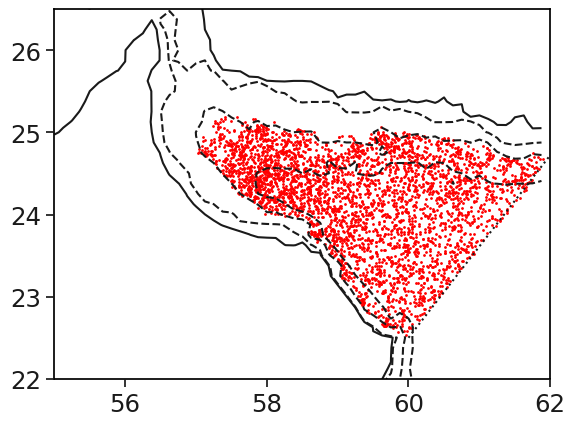

In [4]:
mask_profiles_bathimetry=(df_bath.elevation.interp(lat=ds_grid_argo.latitude, lon=ds_grid_argo.longitude))<-1000
mask_outside_SoO=ds_grid_argo.distance_from_transect_across<200

plt.contour(df_bath.lon[::30], df_bath.lat[::30], df_bath.elevation[::30, ::30], levels=[0], colors='k')
plt.contour(df_bath.lon[::30], df_bath.lat[::30], df_bath.elevation[::30, ::30], levels=[-100], colors='k')
plt.contour(df_bath.lon[::30], df_bath.lat[::30], df_bath.elevation[::30, ::30], levels=[-1000], colors='k')
plt.contour(df_bath.lon[::30], df_bath.lat[::30], df_bath.elevation[::30, ::30], levels=[-2000], colors='k')
# plt.scatter(ds.longitude.values[::1], ds.latitude.values[::1], s=1)
plt.scatter(ds_grid_argo.longitude[mask_profiles_bathimetry & mask_outside_SoO], ds_grid_argo.latitude[mask_profiles_bathimetry & mask_outside_SoO], c='red', s=1)

plt.plot([60,62.25], [22.5, 25], c='k', ls=':')
## plt.scatter(ds.lon_on_transect_across.values[::1], ds.lat_on_transect_across.values[::1], c='r', s=1)
plt.xlim(55,62)
plt.ylim(22, 26.5)  

In [6]:
dsargo=xr.open_dataset('/home/jupyter-estelfont/datasets/argo/ModeWater_SoO/gridded_along_across_SoO_per_month.nc')
dsargo.distance, dsargo.pressure

(<xarray.DataArray 'distance' (distance: 111)> Size: 888B
 array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
         70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135,
        140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205,
        210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275,
        280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345,
        350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415,
        420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485,
        490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550])
 Coordinates:
   * distance  (distance) int64 888B 0 5 10 15 20 25 ... 525 530 535 540 545 550,
 <xarray.DataArray 'pressure' (pressure: 1000)> Size: 8kB
 array([  0,   1,   2, ..., 997, 998, 999], shape=(1000,))
 Coordinates:
   * pressure  (pressure) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999)

In [16]:
# np.nanmean(profile_number_gridded)

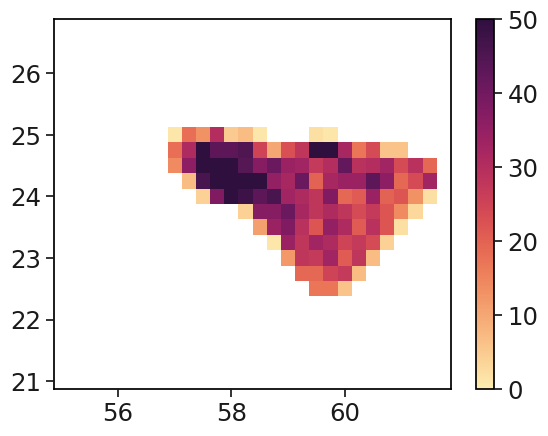

In [17]:
profilenumebrs=ds_grid_argo.profile_number[mask_profiles_bathimetry & mask_outside_SoO]
latitude_bin=np.arange(21,27,0.25)
longitude_bin=np.arange(55,62,0.25)
profile_number_gridded, _, _=sx.grid2d(profilenumebrs.longitude, profilenumebrs.latitude, profilenumebrs.profile_number, xi=longitude_bin, yi=latitude_bin, fn='count')
plt.pcolormesh(longitude_bin, latitude_bin, profile_number_gridded, vmin=0, vmax=50, cmap=cmo.matter)
plt.colorbar()

In [18]:
np.nanmean(profile_number_gridded)

np.float64(27.75)

Text(0, 0.5, 'Depth (m)')

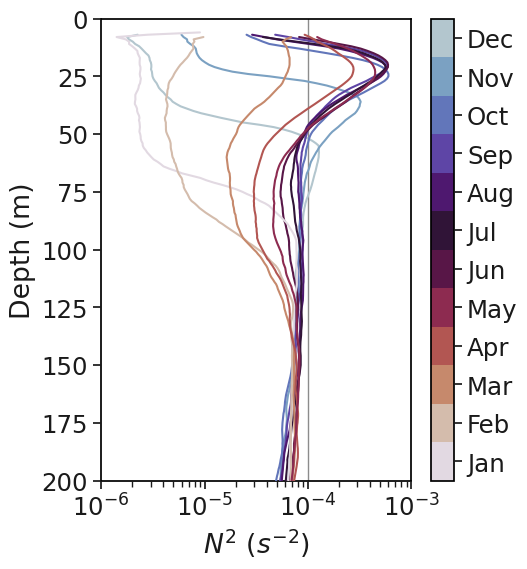

In [19]:
plt.figure(figsize=(5,6))
cmapss = plt.get_cmap('twilight_r', 13)  # 12 colors to avoid cyclic behavior
# for i in [1,2,11, 12]:
    # _=plt.plot(ds_grid_argo_month[i].N2.median('time').where(ds_grid_argo_month[i].N2.mean('time')>0, np.nan).rolling(pressure=10,center=True).mean(), ds_grid_argo.pressure, c=cmapss(i-1))
m=[100, 101, 102, 103, 104, 99,98,97,96,95,94, 93]
# lws=[1,2,2,2,2,1,1,1,1,1,1,1]

for i in range(1, 13,1):
    _=plt.plot(ds_grid_argo_month[i].N2.median('time').where(ds_grid_argo_month[i].N2.mean('time')>0, np.nan).rolling(pressure=10,center=True).mean(), ds_grid_argo.pressure, c=cmapss(i-1), lw=1.5, zorder=m[i-1])
plt.ylim(200,0)
plt.xlim(1e-6, 1e-3)
plt.xscale('log')
plt.axvline()
# Scatter plot data: 12 points representing the 12 months
# Get the RGB color codes (excluding alpha)
colors = plt.get_cmap('twilight_r', 13)(np.linspace(0, 1, 13))[:, :3]  # Extract only RGB values (ignore alpha)
color_list = [tuple(color) for color in colors]
ccmap_12 = ListedColormap(color_list[:-1])

x = np.zeros(12)
y = np.linspace(0, 1, 12)
# Scatter plot with colormap
scatter = plt.scatter(x, y, c=np.arange(0, 12), cmap=ccmap_12, vmin=0, vmax=12)
cb = plt.colorbar(scatter)
cb.set_ticks(np.arange(1, 13) - 0.5)
cb.set_ticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.axvline(1e-4, c='k', alpha=0.5, zorder=-10, lw=1)

plt.xlabel('$N^2$ ($s^{-2}$)')
plt.ylabel('Depth (m)')

(0.0, 400.0)

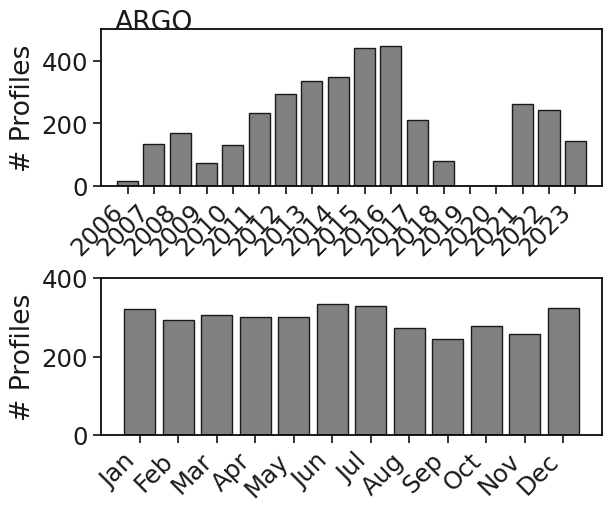

In [20]:
# plt.figure(figsize=(4,4), constrained_layout=True)
new_Ds=ds_grid_argo.profile_number[mask_profiles_bathimetry & mask_outside_SoO].swap_dims({'profile_number':'time'})


plt.figure(figsize=(6,5), constrained_layout=True)

prof_num_per_year=[len(new_Ds.groupby('time.year')[int(i)]) for i in list(new_Ds.groupby('time.year').groups.keys())]
prof_num_per_month=[len(new_Ds.groupby('time.month')[int(i)]) for i in list(new_Ds.groupby('time.month').groups.keys())]
prof_num_per_year=np.insert(prof_num_per_year, 13, 0)
prof_num_per_year=np.insert(prof_num_per_year, 14, 0)


plt.subplot(211)
plt.bar(np.arange(2006, 2024,1), prof_num_per_year, color='gray')
plt.xticks(np.arange(2006, 2024,1), rotation=45 , ha='right')
plt.ylabel('# Profiles')
plt.xlim(2005, 2024)
plt.text(2005.5, 500, s='ARGO')
plt.ylim(0,500)

plt.subplot(212)
plt.bar(list(new_Ds.groupby('time.month').groups.keys()), prof_num_per_month, color='gray')
plt.xticks(list(new_Ds.groupby('time.month').groups.keys()), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45, ha='right' )
plt.xlim(0, 13)
plt.ylabel('# Profiles')
plt.ylim(0,400)

In [22]:
import matplotlib.colors as mcolors

df_bat = xr.open_dataset('/home/jupyter-estelfont/scratch/estel/datasets/bathymetry/gebco_2023_n30.0_s-5.0_w30.0_e80.0.nc')
df_bat=df_bat.where(df_bat.lat>20, drop=True).where(df_bat.lon<62, drop=True).where(df_bat.lon>55, drop=True)

cmap_bat=plt.get_cmap('cmo.deep', 16)


rig=64
fntsiz=20
time_range=['2022-01', '2022-03-20', '2022-07', '2022-09']
ds_79=xr.open_dataset('/home/jupyter-estelfont/datasets/glider_grid/sg79_gridded_time_pressure.nc')
ds1=xr.open_dataset('/home/jupyter-estelfont/datasets/glider_grid/sg79_gridded_time_pressure.nc')

# ds_02=xr.open_dataset('/home/jupyter-estelfont/datasets/glider_grid/sg02_gridded_time_pressure.nc')
# ds_10=xr.open_dataset('/home/jupyter-estelfont/datasets/glider_grid/sg10_gridded_time_pressure.nc')
# ds_57=xr.open_dataset('/home/jupyter-estelfont/datasets/glider_grid/sea057_gridded_time_pressure.nc')

cmap = plt.get_cmap('cmo.tempo', 9)
# cmap = plt.get_cmap('cmo.solar', 9)

# Remove the first (lightest) color
colors = cmap(np.arange(1, 9))  # skip index 0
new_cmap = ListedColormap(colors)

# gsw.distance([60,58.53],[23.65, 22.5])/1000

In [27]:
# Starting point
x0, y0 = 59.5, 21.8
# Angle in degree8s
angle_deg = 57.5
# Length of the line
length = 5

# Convert angle to radians
angle_rad = np.deg2rad(angle_deg)

# Calculate endpoint
x1 = x0 + length * np.cos(angle_rad)
y1 = y0 + length * np.sin(angle_rad)

# Plot


## PLOT FIGURE 1

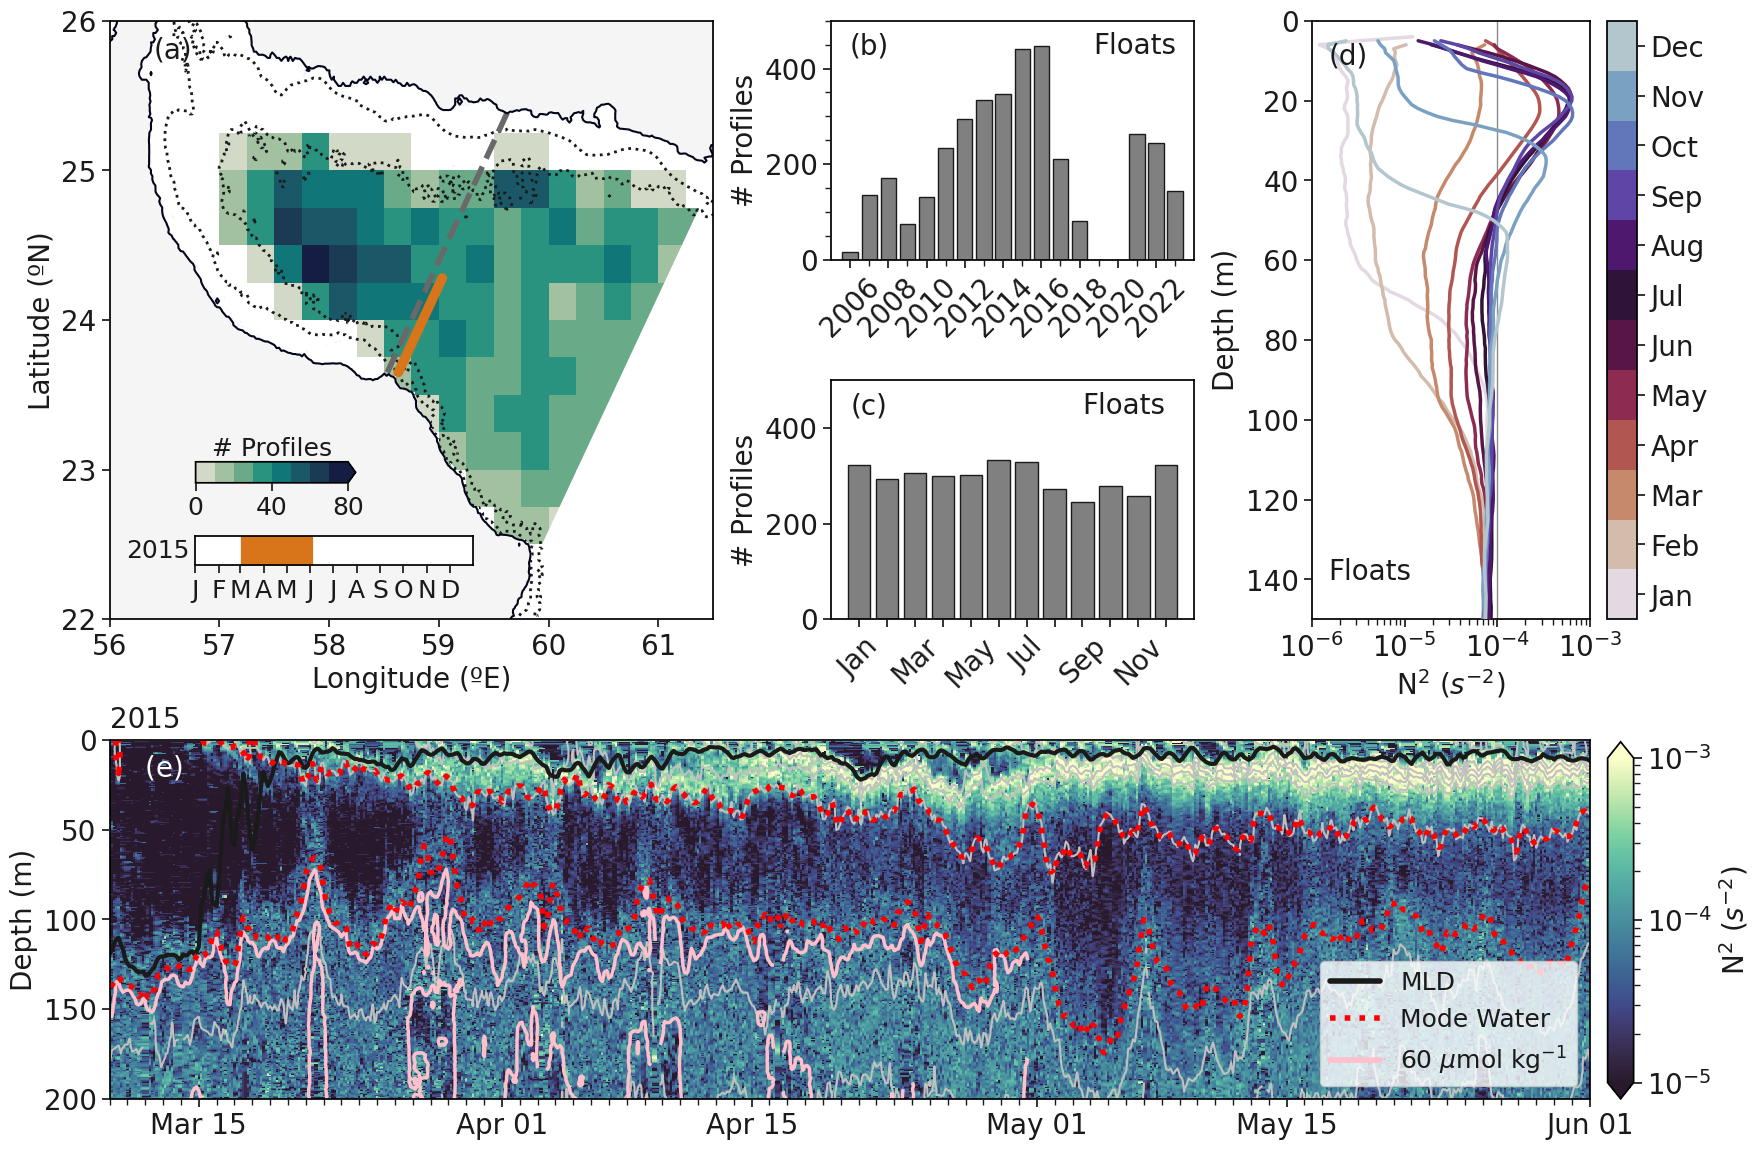

In [29]:

gs = GridSpec(180, 200)
fig = plt.figure(figsize=(20,14), constrained_layout=True)

ax1 = fig.add_subplot(gs[:100, :78])
# cb=ax1.pcolormesh(df_bat.lon,df_bat.lat,-df_bat.elevation.where(df_bat.elevation<0, np.nan), cmap=cmap_bat, vmin=0, vmax=4000, zorder=10)

cb=ax1.pcolormesh(longitude_bin+0.25/2, latitude_bin+0.25/2, profile_number_gridded, vmin=0, vmax=80, cmap=new_cmap, zorder=-10, )
plt.fill_between([x0, x1], [y0, y1], color='white', zorder=-9,)

# plt.colorbar()
ax1.contour(df_bat.lon[::5],df_bat.lat[::5],df_bat.elevation[::5, ::5],levels=[-1000, -100], linewidths=2, linestyles=':', colors='k', zorder=0)

plt.text(56.4, 25.75, s='(a)', fontsize=fntsiz,  zorder=100)
ax1.set_xlim(56, 61.5)
ax1.set_ylim(22, 26)

ax1.set_ylabel('Latitude (ºN)',   fontsize=fntsiz)
ax1.set_xlabel('Longitude (ºE)',   fontsize=fntsiz)

colors= ["#019ff4",
"#d87419"]
plt.plot([58.53,59.65],[23.65, 25.43], lw=4, c='dimgray', ls='--', zorder=0)
plt.plot([58.63,59.03],[23.65, 24.28], lw=7, c=colors[1], zorder=0)
# plt.plot([57.4931,57.9126],[24.0397,24.6507],lw=6,c=colors[1], zorder=100)
ax1.contourf(df_bat.lon,df_bat.lat, df_bat.elevation,  levels=[-1,3000], alpha=1, colors='whitesmoke', zorder=1)
ax1.contour(df_bat.lon[::5],df_bat.lat[::5],df_bat.elevation[::5, ::5],levels=[0], linewidths=1.5, zorder=1)

ax1.yaxis.set_ticks(np.arange(22,27, 1))
ax1.xaxis.set_ticks(np.arange(56, 62, 1))

# plt.plot([x0, x1], [y0, y1], c='k', ls=':')

ax1.tick_params(axis='both', labelsize=fntsiz)

# cbaxes = fig.add_axes([0.195, 0.55, 0.08, 0.015]) 
cbaxes = fig.add_axes([0.168 , 0.55, 0.08, 0.015]) 

cbb=plt.colorbar(cb, cax=cbaxes, ticks=np.arange(0,81, 40), extend='max', orientation='horizontal')
cbb.set_label('# Profiles', fontsize=fntsiz-2)
cbb.ax.tick_params(labelsize=fntsiz-2)
cbb.ax.xaxis.set_label_position('top')  # Move label to the top

delta=4
top=63+2*delta+1
rig,lf=11,44
ax1 = fig.add_subplot(gs[top+3*delta+2:top+4*delta+3, rig:lf+3])

ax1.scatter(ds1.time.values[::1], np.zeros(len(ds1.time.values[::1])), c=colors[1], s=1000, marker='|' )    
ax1.set_xlim(pd.to_datetime('2015-01'), pd.to_datetime('2015-12-31'))
ax1.set_xticks([])
ax1.tick_params(axis='both', labelsize=fntsiz-2)
ax1.set_yticks([])
ax1.set_ylabel('2015', rotation=360, va="center", ha='right', fontsize=fntsiz-2)


ax1.set_ylim(-1,1)
ax1.set_xticks([])
ax1.tick_params(axis='both', labelsize=fntsiz-2)
ax1.set_yticks([])
# ax1.set_ylabel('2022', rotation=360, va="center", ha='right', fontsize=fntsiz-2)

month_fmt = mdates.DateFormatter('%b')
def m_fmt(x, pos=None):
    return month_fmt(x)[0]

ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(m_fmt)
ax1.xaxis.set_major_formatter(m_fmt)
ax1.tick_params(axis='both', labelsize=fntsiz-2)
# ax1.set_xlabel('Month', fontsize=fntsiz-2)

new_Ds=ds_grid_argo.profile_number[mask_profiles_bathimetry & mask_outside_SoO].swap_dims({'profile_number':'time'})

prof_num_per_year=[len(new_Ds.groupby('time.year')[int(i)]) for i in list(new_Ds.groupby('time.year').groups.keys())]
prof_num_per_month=[len(new_Ds.groupby('time.month')[int(i)]) for i in list(new_Ds.groupby('time.month').groups.keys())]
prof_num_per_year=np.insert(prof_num_per_year, 13, 0)
prof_num_per_year=np.insert(prof_num_per_year, 14, 0)


ax2 = fig.add_subplot(gs[:40, 93:140])
plt.bar(np.arange(2006, 2024,1), prof_num_per_year, color='gray')
plt.xticks(np.arange(2006, 2024,2), rotation=45)
# Minor ticks: np.arange from 0 to 10 with step size of 0.2 (you can adjust this)
plt.minorticks_on()
plt.gca().set_xticks(np.arange(2007, 2024,2), minor=True)

plt.ylabel('# Profiles',   fontsize=fntsiz)
plt.xlim(2005, 2024)
plt.text(2006, 430, s='(b)',   fontsize=fntsiz)
plt.text(2018.7, 430, s='Floats',   fontsize=fntsiz, zorder=10000)

plt.ylim(0,500)
ax2.tick_params(axis='both', labelsize=fntsiz)

ax2 = fig.add_subplot(gs[60:100, 93:140])
plt.text(0.7, 430, s='(c)',   fontsize=fntsiz)
plt.text(9, 430, s='Floats',   fontsize=fntsiz, zorder=10000)

plt.bar(list(ds_grid_argo.groupby('time.month').groups.keys()), prof_num_per_month, color='gray')
plt.xticks(list(ds_grid_argo.groupby('time.month').groups.keys()), labels=['Jan', '', 'Mar', '', 'May', '', 'Jul', '', 'Sep', '', 'Nov', ''], rotation=45 )
plt.xlim(0, 13)
plt.ylabel('# Profiles',   fontsize=fntsiz)
plt.ylim(0,500)
ax2.tick_params(axis='both', labelsize=fntsiz)



ax2 = fig.add_subplot(gs[:100, 155:])
plt.text(1.5e-6, 11, s='(d)',   fontsize=fntsiz, zorder=10000)
plt.text(1.5e-6, 140, s='Floats',   fontsize=fntsiz, zorder=10000)

cmapss = plt.get_cmap('twilight_r', 13)  # 12 colors to avoid cyclic behavior
# for i in [1,2,11, 12]:
    # _=plt.plot(ds_grid_argo_month[i].N2.median('time').where(ds_grid_argo_month[i].N2.mean('time')>0, np.nan).rolling(pressure=10,center=True).mean(), ds_grid_argo.pressure, c=cmapss(i-1))
for i in range(1, 13,1):
    _=plt.plot(ds_grid_argo_month[i].N2.median('time').where(ds_grid_argo_month[i].N2.mean('time')>0, np.nan).rolling(pressure=7,center=True).mean(), 
               ds_grid_argo.pressure, c=cmapss(i-1), zorder=100, lw=2.5)
plt.ylim(150,0)
plt.xlim(1e-6, 1e-3)
plt.xscale('log')
plt.axvline()
# Scatter plot data: 12 points representing the 12 months
# Get the RGB color codes (excluding alpha)
colors = plt.get_cmap('twilight_r', 13)(np.linspace(0, 1, 13))[:, :3]  # Extract only RGB values (ignore alpha)
color_list = [tuple(color) for color in colors]
ccmap_12 = ListedColormap(color_list[:-1])

x = np.zeros(12)
y = np.linspace(0, 1, 12)
# Scatter plot with colormap
scatter = plt.scatter(x, y, c=np.arange(0, 12), cmap=ccmap_12, vmin=0, vmax=12)
cb = plt.colorbar(scatter)
cb.set_ticks(np.arange(1, 13) - 0.5)
cb.set_ticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],   fontsize=fntsiz)

plt.axvline(1e-4, c='k', alpha=0.5, zorder=-10, lw=1)

plt.xlabel('N$^2$ ($s^{-2}$)',   fontsize=fntsiz)
plt.ylabel('Depth (m)',   fontsize=fntsiz)

ax2.tick_params(axis='both', labelsize=fntsiz)


time_filt=1
vert_filt=3

min_n2=1e-5
a,b,c =111, 38, 34

ax1 = fig.add_subplot(gs[120:, :191])

ds_grid=ds_79.copy()
plt.text(pd.to_datetime('2015-03-10'), -7, s='2015', fontsize=fntsiz,  zorder=100)


n2=ds_grid['N2'].bfill('pressure').rolling(pressure=vert_filt, center=True).mean().rolling(time=time_filt, center=True).median()
n2=n2.where(n2>1e-10, np.nan)

cn2=plt.pcolormesh(
            ds_grid.time, ds_grid.pressure,
            n2.ffill('time'),
             cmap='cmo.deep_r', norm=mcolors.LogNorm(vmin=min_n2, vmax=1e-3))

# cn2=plt.pcolormesh(
#             ds_grid.time, ds_grid.pressure,
#             ds_grid['N2'].rolling(pressure=vert_filt, center=True).mean().rolling(time=time_filt, center=True).median().bfill('pressure'),
#              cmap='cmo.deep_r', norm=mcolors.LogNorm(vmin=min_n2, vmax=1e-3))

cc=plt.contour(
            ds_grid.time, ds_grid.pressure,
            ds_grid['potential_density'].rolling(time=time_filt, center=True).mean()
                         .rolling(pressure=vert_filt, center=True).mean().bfill('pressure'),
             levels=np.arange(22,28,0.5), colors='silver', linewidths=1.5, alpha=1)

cmap_o2=plt.get_cmap('cmo.ice_r', 9)
time_filt=3
plt.plot(ds_grid.time, ds_grid.mixed_layer_depth.rolling(time=5, center=True).mean(), lw=3, c='k')

smthso2=ds_79['oxygen_concentration'].rolling(time=time_filt, center=True).mean().rolling(pressure=vert_filt, center=True).mean().bfill('pressure')
smthso2=smthso2.where(smthso2.time != smthso2.time[461], np.nan)
cc=plt.contour(
            ds_grid.time, ds_grid.pressure,smthso2,
             levels=[60], colors=['pink'], linewidths=2.5, labels=['60 $\mu$mol kg$^{-1}$'])
# Create custom legend
labels = ['MLD', 'Mode Water', '60 $\mu$mol kg$^{-1}$']
handles = [ plt.Line2D([0], [0], color='k', lw=4), plt.Line2D([0], [0], color='red', ls=':', lw=4),
           plt.Line2D([0], [0], color='pink', lw=4)]

plt.contour(
            ds_grid.time, ds_grid.pressure,
            ds_grid['potential_density'].rolling(time=time_filt, center=True).mean()
                         .rolling(pressure=vert_filt, center=True).mean().bfill('pressure'),
             levels=[25, 25.25], colors='red',linestyles=':', linewidths=4, alpha=1)

# Add the legend to the plot
plt.legend(handles=handles, labels=labels, loc='lower right', fontsize=fntsiz-2)

# plt.plot(ds_grid.time, ds_grid.mixed_layer_depth.rolling(time=5, center=True).mean(), c='k')
plt.ylim(200, 0)


plt.xlim(pd.to_datetime('2015-03-10'), pd.to_datetime('2015-06-01'))
ax1.set_ylabel('Depth (m)',   fontsize=fntsiz)
ax1.tick_params(axis='both', labelsize=fntsiz)
# plt.get_cmap('cmo.ice_r', 9)


# 

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gca().xaxis.set_minor_locator(mdates.DayLocator(interval=1))

# for ax in [ax1]:
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
#     ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
#     ax.tick_params(axis='both', labelsize=fntsiz)
    
plt.text(pd.to_datetime('2015-03-12'), 20, s='(e) ', c='w', fontsize=fntsiz,  zorder=100)



# ax1cb = fig.add_subplot(gs[120:, 192:])
# ax1cb.set_visible(False)

cbar_ax = fig.add_axes([0.874, 0.11, 0.013, 0.255])  # Adjust as needed

# Create the colorbar
cbb = fig.colorbar(cn2, cax=cbar_ax, ticks=[1e-5, 1e-4, 1e-3], extend='both')
cbb.set_label('N$^2$ ($s^{-2}$)', fontsize=fntsiz)
cbb.ax.tick_params(labelsize=fntsiz)

plt.savefig('Fig1.png', dpi=600)


## PLOT FIGURE S1

Text(0.5, 1.0, 'PV< median PV (2.5e-10)')

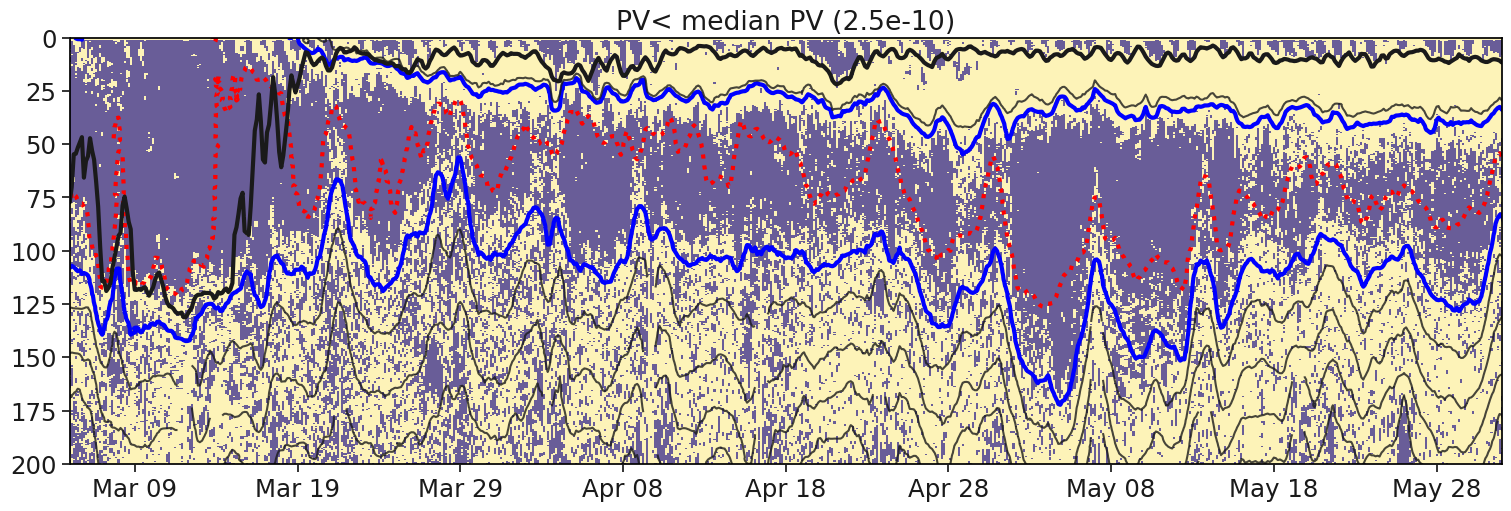

In [111]:
ds_79_tid=xr.open_dataset('/home/jupyter-estelfont/datasets/glider_grid/sg79_gridded_time_pressure.nc')
# ds_79_tid=ds_79_tid.sel(time=slice(pd.to_datetime('2015-03-25'), pd.to_datetime('2015-05-01')))
ds_79_tids=xr.open_dataset('/home/jupyter-estelfont/datasets/glider_grid/sg79_gridded_time_sigma.nc')
# ds_79_tids=ds_79_tids.sel(time=slice(pd.to_datetime('2015-03-25'), pd.to_datetime('2015-05-01')))

## ADD RESPIRATION RATES
fig, ax = plt.subplots(figsize=(15, 5), constrained_layout=True)

ds_79_tid['PV_roll']=ds_79_tid['PV'].rolling(pressure=5, center=True).mean()
plt.pcolormesh(ds_79_tid.time, ds_79_tid.pressure,ds_79_tid.PV_roll.where(ds_79_tid.PV_roll<np.nanpercentile(np.abs(ds_79_tid.PV_roll.values.flatten()), 50), 1), cmap=cmo.haline, alpha=0.7)
# plt.colorbar()
# plt.colorbar()
plt.ylim(200,0)
plt.contour(ds_79_tid.time, ds_79_tid.pressure, ds_79_tid.potential_density.rolling(time=5, center=True).mean(), levels=[24.9,25.1,25.25], colors=['blue', 'red', 'blue'], linestyles=['-', ':', '-'] , linewidths=3)
plt.contour(ds_79_tid.time, ds_79_tid.pressure, ds_79_tid.potential_density.rolling(time=5, center=True).mean(),levels=[24.8,25.4, 25.6,  25.8,26, 26.2, 26.4, 26.6, 26.8, 27], colors=['k'], alpha=0.8 )
plt.xlim(pd.to_datetime('2015-03-05'), pd.to_datetime('2015-06-01'))
plt.plot(ds_79_tid.time, ds_79_tid.mixed_layer_depth.rolling(time=5, center=True).mean(), c='k', lw=3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))

plt.title('PV< median PV (2.5e-10)')

Text(0.01, 0.95, '(d)')

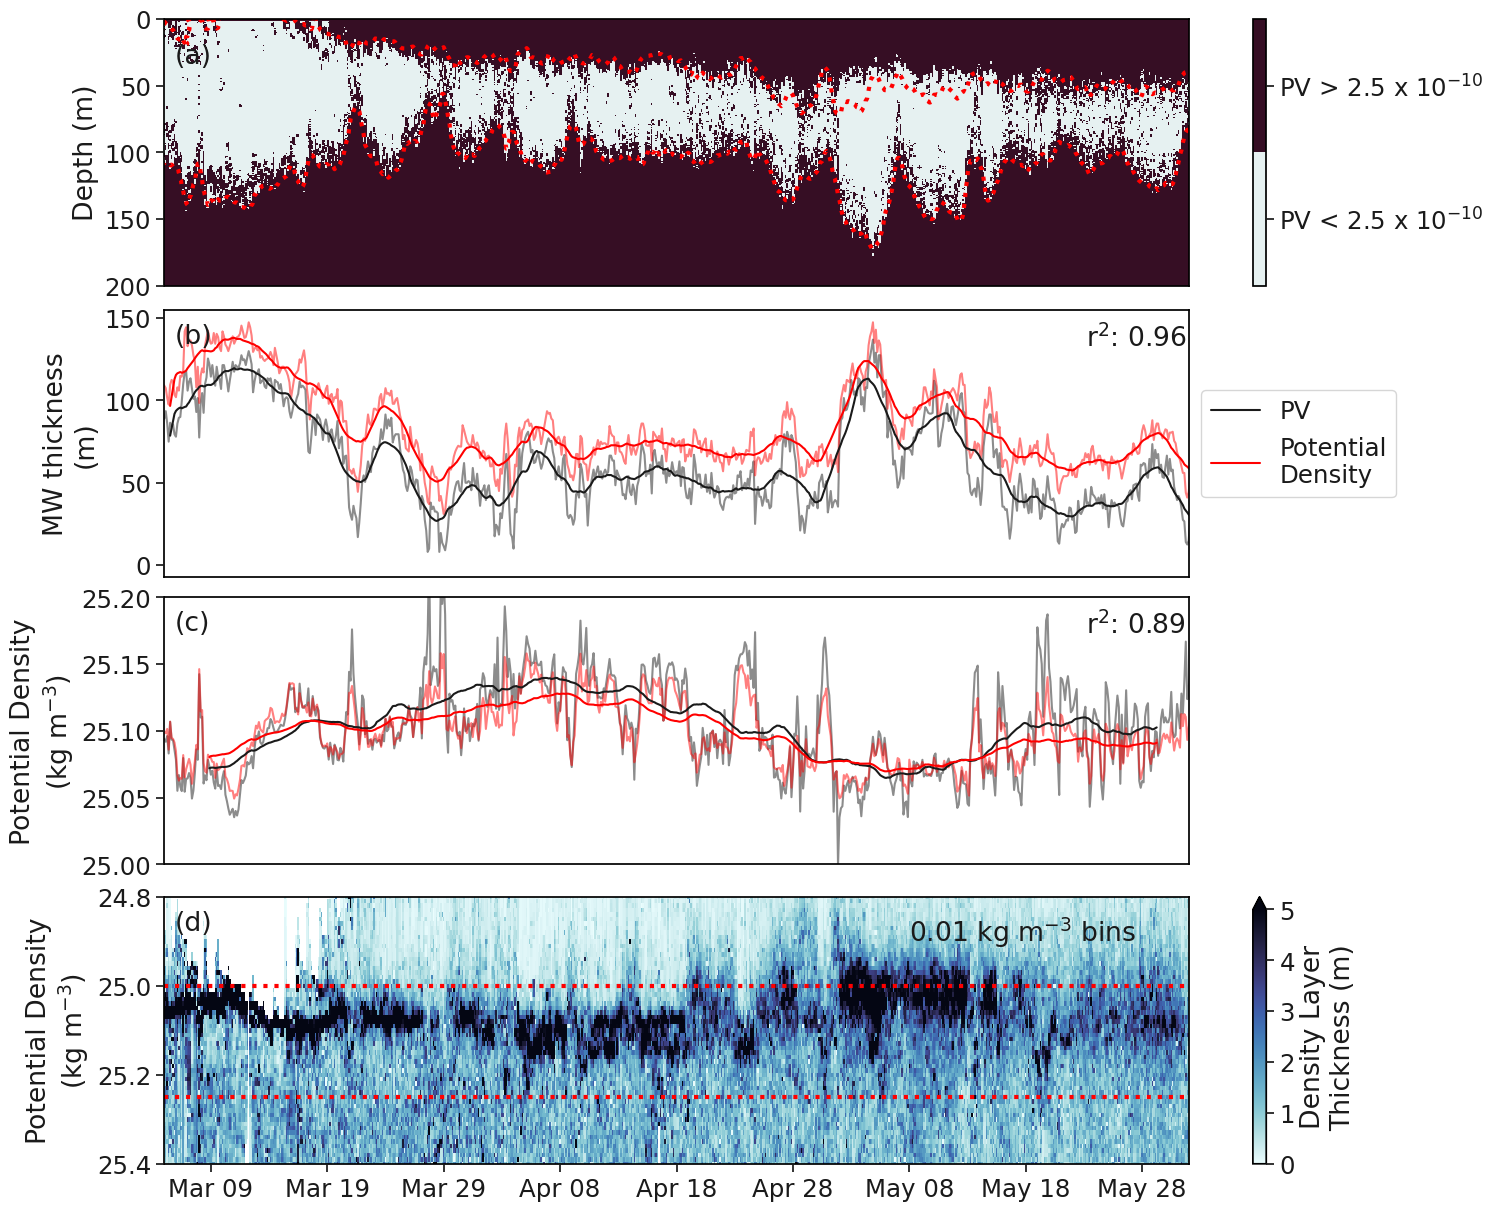

In [186]:
PV_subsel=ds_79_tid['PV_roll'].where(ds_79_tid['potential_density']<25.25, np.nan).where(ds_79_tid['potential_density']>24.9, np.nan)
fig = plt.figure(figsize=(15, 12), constrained_layout=True)
plt.subplot(411)
# plt.title('PV< median PV (2.5e-10);; sigma [24.95,25.1,25.25]')
plt.pcolormesh(ds_79_tid.time, ds_79_tid.pressure, np.isnan(PV_subsel.where(PV_subsel<np.nanpercentile(np.abs(ds_79_tid.PV_roll.values.flatten()), 50), np.nan)), cmap=plt.get_cmap('cmo.dense', 2))
plt.ylim(200,0)
plt.text(0.01, 0.91, '(a)', transform=plt.gca().transAxes, va='top')

plt.ylabel('Depth (m)')
cbar=plt.colorbar(ticks=[0.25, 0.75],pad=-0.14)
cbar.set_ticklabels(['PV < 2.5 x 10$^{-10}$', 'PV > 2.5 x 10$^{-10}$'])
plt.contour(ds_79_tid.time, ds_79_tid.pressure, ds_79_tid.potential_density.rolling(time=5, center=True).mean(), levels=[25,25.25], colors=['red', 'red'], linestyles=[':', ':'] , linewidths=3)
# plt.contour(ds_79_tid.time, ds_79_tid.pressure, ds_79_tid.potential_density.rolling(time=5, center=True).mean(),levels=[24.8,25.4, 25.6,  25.8,26, 26.2, 26.4, 26.6, 26.8, 27], colors=['k'], alpha=0.8 )
plt.xlim(pd.to_datetime('2015-03-05'), pd.to_datetime('2015-06-01'))
# plt.axvline(pd.to_datetime('2015-03-19'), c='red')
plt.xticks([])
plt.subplot(412)
plt.plot(PV_subsel.time, 
         (~np.isnan(PV_subsel.where(PV_subsel<np.nanpercentile(np.abs(ds_79_tid.PV_roll.values.flatten()), 50), np.nan))).astype(float).sum(axis=0)*0.5, 
        c='k',alpha=0.5)
plt.plot(PV_subsel.time,
         (~np.isnan(ds_79_tid['potential_density'].where(ds_79_tid['potential_density']<25.25, np.nan).where(ds_79_tid['potential_density']>24.95, np.nan).astype(float))).astype(float).sum(axis=0)*0.5, 
        c='red',alpha=0.5)


plt.plot(PV_subsel.time, 
         pd.DataFrame((~np.isnan(PV_subsel.where(PV_subsel<np.nanpercentile(np.abs(ds_79_tid.PV_roll.values.flatten()), 50), np.nan))).astype(float).sum(axis=0)*0.5).rolling(25, center=True).mean(), 
        c='k', label='PV')
plt.plot(PV_subsel.time,
         pd.DataFrame((~np.isnan(ds_79_tid['potential_density'].where(ds_79_tid['potential_density']<25.25, np.nan).where(ds_79_tid['potential_density']>24.95, np.nan).astype(float))).astype(float).sum(axis=0)*0.5).rolling(25, center=True).mean(), 
        c='red', label='Potential\nDensity',)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('MW thickness\n(m)')
plt.xlim(pd.to_datetime('2015-03-05'), pd.to_datetime('2015-06-01'))
# plt.axvline(pd.to_datetime('2015-03-19'), c='red')
plt.text(0.01, 0.95, '(b)', transform=plt.gca().transAxes, va='top')
plt.text(0.9, 0.95, 'r$^{2}$: 0.96', transform=plt.gca().transAxes, va='top')

plt.xticks([])
plt.subplot(413)
sig_subsel=ds_79_tid['potential_density'].where(ds_79_tid['potential_density']<25.25, np.nan).where(ds_79_tid['potential_density']>24.9, np.nan)
# PV_subsel=ds_79_tid['potential_density'].where(ds_79_tid['potential_density']<25.25, np.nan).where(ds_79_tid['potential_density']>24.9, np.nan)

plt.plot(PV_subsel.time, sig_subsel.where(PV_subsel<np.nanpercentile(np.abs(ds_79_tid.PV_roll.values.flatten()), 50), np.nan).mean(axis=0), c='k', alpha=.5)
plt.plot(PV_subsel.time,sig_subsel.mean(axis=0),  c='red',alpha=.5)

plt.plot(PV_subsel.time, sig_subsel.where(PV_subsel<np.nanpercentile(np.abs(ds_79_tid.PV_roll.values.flatten()), 50), np.nan).mean(axis=0).rolling(time=73, center=True).mean(), c='k', label='PV_criteria')
plt.plot(PV_subsel.time,sig_subsel.mean(axis=0).rolling(time=73, center=True).mean(),  c='red', label='Sigma_criteria')

# plt.legend()
plt.ylabel('Potential Density\n(kg m$^{-3}$)')
plt.xlim(pd.to_datetime('2015-03-05'), pd.to_datetime('2015-06-01'))
# plt.axvline(pd.to_datetime('2015-03-19'), c='red')
plt.ylim(25,25.2)
plt.xticks([])
plt.text(0.01, 0.95, '(c)', transform=plt.gca().transAxes, va='top')
plt.text(0.9, 0.95, 'r$^{2}$: 0.89', transform=plt.gca().transAxes, va='top')

plt.subplot(414)
plt.pcolormesh(ds_79_tids.time,ds_79_tids.potential_density[:-1], np.abs(ds_79_tids.pressure.diff('potential_density')), vmin=0, vmax=5, cmap=cmo.ice_r)
plt.colorbar(label='Density Layer\nThickness (m)', extend='max', pad=-0.14)
plt.ylim(25.4,24.8)
plt.xlim(pd.to_datetime('2015-03-05'), pd.to_datetime('2015-06-01'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
# plt.axhline(25.1, c='red', ls=':')
plt.axhline(25,ls=':', c='red', lw=3)
plt.axhline(25.25,ls=':', c='red', lw=3)
# plt.axvline(pd.to_datetime('2015-03-19'), c='red')
plt.ylabel('Potential Density\n(kg m$^{-3}$)')
plt.text(pd.to_datetime('2015-05-08'), 24.9, '0.01 kg m$^{-3}$ bins')

plt.text(0.01, 0.95, '(d)', transform=plt.gca().transAxes, va='top')


In [185]:
# (~np.isnan(PV_subsel.where(PV_subsel<np.nanpercentile(np.abs(ds_79_tid.PV_roll.values.flatten()), 50), np.nan))).astype(float).sum(axis=0)*0.5

In [123]:
# xx_.values

Slope: 0.873
Intercept: 28.624
R²: 0.9634703181706182


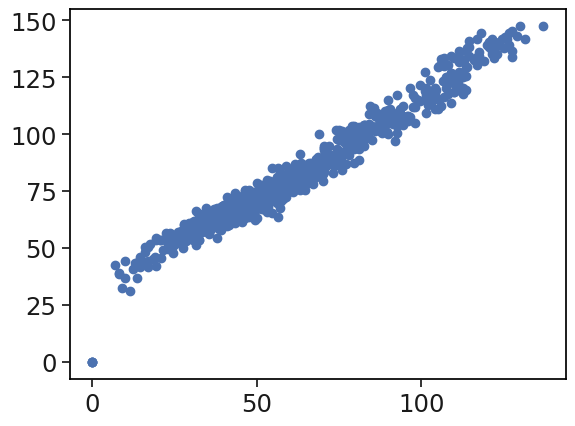

In [128]:
xx_=((~np.isnan(PV_subsel.where(PV_subsel<np.nanpercentile(np.abs(ds_79_tid.PV_roll.values.flatten()), 50), np.nan))).astype(float).sum(axis=0)*0.5).values
yy_= ((~np.isnan(ds_79_tid['potential_density'].where(ds_79_tid['potential_density']<25.25, np.nan).where(ds_79_tid['potential_density']>24.95, np.nan).astype(float))).astype(float).sum(axis=0)*0.5).values
plt.scatter(xx_, yy_)

# np.poly1d(xx_, yy_)


from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

mask = ~np.isnan(xx_) & ~np.isnan(yy_)
x_clean = xx_[mask].reshape(-1, 1)  # sklearn expects 2D input for X
y_clean = yy_[mask]

# Fit linear regression
model = LinearRegression()
model.fit(x_clean, y_clean)
slope = model.coef_[0]
intercept = model.intercept_
r2 = model.score(x_clean, y_clean)

# Print results
print(f"Slope: {slope:.3f}")
print(f"Intercept: {intercept:.3f}")
print(f"R²: {r2}")

Slope: 0.658
Intercept: 8.579
R²: 0.8767683970530291


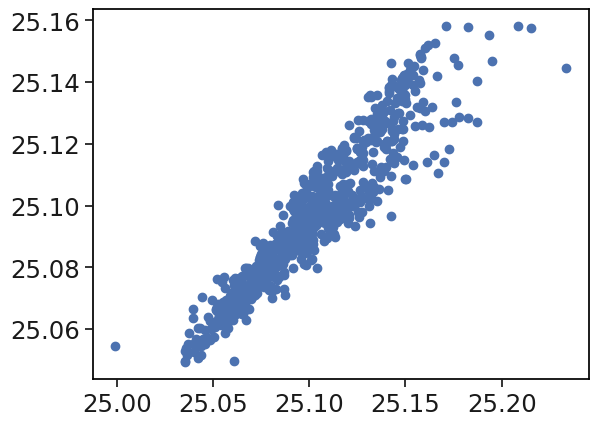

In [133]:
xx_=sig_subsel.where(PV_subsel<np.nanpercentile(np.abs(ds_79_tid.PV_roll.values.flatten()), 50), np.nan).mean(axis=0).values
yy_=sig_subsel.mean(axis=0).values

plt.scatter(xx_, yy_)

# np.poly1d(xx_, yy_)


from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

mask = ~np.isnan(xx_) & ~np.isnan(yy_)
x_clean = xx_[mask].reshape(-1, 1)  # sklearn expects 2D input for X
y_clean = yy_[mask]

# Fit linear regression
model = LinearRegression()
model.fit(x_clean, y_clean)
slope = model.coef_[0]
intercept = model.intercept_
r2 = model.score(x_clean, y_clean)

# Print results
print(f"Slope: {slope:.3f}")
print(f"Intercept: {intercept:.3f}")
print(f"R²: {r2}")